In [18]:
import os
import torch
import torchvision
import numpy as np
#import tarfile
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.datasets.utils import download_url
#from torchvision.datasets import CIFAR100
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from PIL import Image, ImageEnhance
import nibabel as nib
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [19]:
file = './ISLES/TRAINING/case_3/SMIR.Brain.XX.O.CT.345576/SMIR.Brain.XX.O.CT.345576.nii'
mask = './ISLES/TRAINING/case_3/SMIR.Brain.XX.O.OT.345580/SMIR.Brain.XX.O.OT.345580.nii'

In [20]:
img = nib.load(file)
mask = nib.load(mask)

In [21]:
img.shape
mask.shape

(256, 256, 8)

In [22]:
def cbControl(section):
    alpha = 2.0 # Simple contrast control
    beta = 1.0    # Simple brightness control

    for y in range(section.shape[0]):
        for x in range(section.shape[1]):
                section[y,x] = np.clip(alpha*section[y,x] + beta, 0, 255)
    

In [36]:
H_min = -50
H_max = 1000
H_range = H_max - H_min

def normalizeImageIntensityRange(img):
    img[img < H_min] = H_min
    img[img > H_max] = H_max
    return (img - H_min) / H_range

In [48]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

(256, 256, 8)
(256, 256)
40.0 80.0


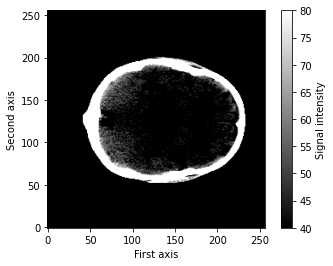

In [49]:
img_data = img.get_fdata()
mask_data = mask.get_fdata()
print(img_data.shape)

section = img_data[:,:,5]
print(section.shape)

section.shape

min=np.min(section)        # result=-23.0
max=np.max(section)        # result=2213.0
print(min,max)

nImg = window_image(section,45,1000)



plt.imshow(nImg, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

In [7]:
# Converting to tensor

section_data = torch.from_numpy(section)

In [8]:
section_data.shape

torch.Size([256, 256])